## Train and Deploy a CNN Model Using TensorFlow Serving


### DESCRIPTION

###  Problem Statement:

You’re a Computer Vision Engineer at health.ai. Your company is developing a deep learning application to automate the detection of diabetic retinopathy. The company is sourcing high-resolution retina image data from various clinical partners but the dataset is expected to be huge and cannot be stored on a central system. You’re asked to build a proof of concept using the Kaggle retinopathy dataset to train a CNN model with the Mirrored Strategy and deploy it with TensorFlow Serving. 

 

### Objective: To build a CNN model using distributed training that can detect diabetic retinopathy and deploy it using TensorFlow Serving.

     

### Dataset Details: 

The dataset contains a large set of high-resolution retina images taken under a variety of imaging conditions. A left and right field is provided for every subject. Images are labeled with a subject id as well as either left or right. A clinician has rated the presence of diabetic retinopathy in each image on a scale of 0 to 4. Like any real-world dataset, you will encounter noise in both the images and labels. Images may contain artifacts, be out of focus, underexposed, or overexposed. 

 

Link to the Dataset: https://www.dropbox.com/sh/7z7xq2lq3ogspcv/AACF_50dOtFaVYoII80abNPLa?dl=0

     

### Prerequisites:

TensorFlow

Keras

TensorFlow Serving

#### Steps to be followed: 

Download and preprocess the dataset to correct for noise and under and over exposure

Augment the dataset and split it into training and test sets

Define the distributed training strategy

Define the number of shared instances

Define a CNN architecture to extract features from the model data

Define parameters like the loss, optimizer, epochs, learning rate, and evaluation metric

Define checkpoints

Train the model until an accuracy of at least 80% is obtained

Save the model

Deploy the saved model using TensorFlow Serving

In [156]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Download the Data
https://www.dropbox.com/sh/7z7xq2lq3ogspcv/AACF_50dOtFaVYoII80abNPLa?dl=0

In [157]:
import numpy as np 
import pandas as pd 
import os
import random
import sys

import cv2

import csv
import matplotlib
from subprocess import check_output

In [ ]:
#### In the AWS machine, upload the image files as a zip file, then unzip using the following 
#import zipfile
#with zipfile.ZipFile("dataset.zip","r") as zip_ref:
#    zip_ref.extractall("/root")

In [158]:
#importing the os module
import os

#to get the current working directory
directory = os.getcwd()

print(directory)

/content


In [159]:
import tensorflow

In [160]:
tensorflow.__version__

'2.8.0'

In [161]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

import keras
import tensorflow as tf
import cv2

#### Define the variables

In [162]:
NUM_CLASSES = 5

WIDTH  = 128
HEIGHT = 128
DEPTH  = 3

inputShape = (HEIGHT, WIDTH, DEPTH)

EPOCHS  = 15
INIT_LR = 1e-3

BS = 8

#### Reading the training data

In [163]:
location_train=r'/content/drive/MyDrive/ML/project/dataset/train/data'  
print(location_train)

/content/drive/MyDrive/ML/project/dataset/train/data


About the downloaded data
- excel file
    - file_name and level of disease
        - patient_ID is in the filename
- dataset folder(unzipped)
    - all the images 
        - all the patients
            - patient_ID
            
write a script to organize the images as per the classes (keras needs it)
- dataset
    - images
        - all downloaded images
    - excel sheet
- root
    - train
        - 0 
        - 1
        - 2
        - 3
        - 4
    - val
        - 0
        - 1
        - 2
        - 3
        - 4
    - test
        - 0
        - 1
        - 2
        - 3
        - 4

#### Loop over all the images

In [164]:
images = os.listdir(location_train)

In [165]:
print("Number of files in = " + str(len(images)))

Number of files in = 1427


In [166]:
from keras.preprocessing.image import array_to_img, img_to_array, load_img

#### Check few images

In [167]:
imageFullPath = os.path.join(os.path.sep, location_train, '876_left.jpeg')
imageFullPath

'/content/drive/MyDrive/ML/project/dataset/train/data/876_left.jpeg'

In [168]:
img = load_img(imageFullPath)
img = img_to_array(img)
img = img/255
img.shape

(2592, 3888, 3)

In [169]:
import matplotlib.pyplot as plt

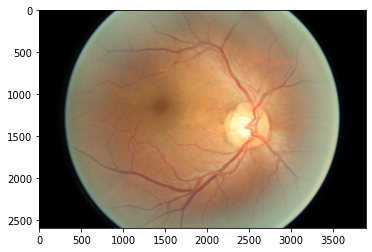

In [170]:
plt.imshow(img);

In [171]:
scale_percent = 10                 # percent of original size

width  = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)

dim = (width, height)
dim

(388, 259)

In [172]:
# resize image
resized_img1 = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
resized_img2 = cv2.resize(img, dim, interpolation = cv2.INTER_NEAREST)
resized_img3 = cv2.resize(img, dim, interpolation = cv2.INTER_CUBIC) 
resized_img4 = cv2.resize(img, dim, interpolation = cv2.INTER_LANCZOS4) 

print('Resized Dimensions : ',resized_img1.shape)

Resized Dimensions :  (259, 388, 3)


In [173]:
resized_img2[:1]

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

OpenCV uses `BGR` as its default colour order for images, matplotlib uses `RGB`. When you display an image loaded with OpenCv in matplotlib the channels will be back to front.

The easiest way of fixing this is to use OpenCV to explicitly convert it back to RGB, much like you do when creating the greyscale image.

In [174]:
img          = cv2.cvtColor(img,          cv2.COLOR_BGR2RGB)
resized_img1 = cv2.cvtColor(resized_img1, cv2.COLOR_BGR2RGB)
resized_img2 = cv2.cvtColor(resized_img2, cv2.COLOR_BGR2RGB)
resized_img3 = cv2.cvtColor(resized_img3, cv2.COLOR_BGR2RGB)
resized_img4 = cv2.cvtColor(resized_img4, cv2.COLOR_BGR2RGB)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


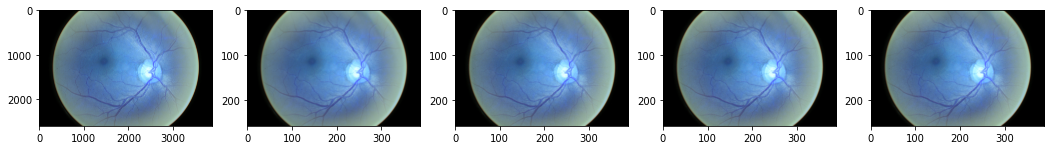

In [175]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(18, 4))

ax[0].imshow(img)
ax[1].imshow(resized_img1)
ax[2].imshow(resized_img2)
ax[3].imshow(resized_img3)
ax[4].imshow(resized_img4);

#### read the meta data on images

A clinician has rated the presence of diabetic retinopathy in each image on a scale of 0 to 4, according to the following scale:

|level| description|
|-----| -----------|
|0 -  | No DR      |
|1 - |Mild|
|2 - |Moderate|
|3 - |Severe|
|4 - |Proliferative DR|

In [176]:
location_train_labels = r'/content/drive/MyDrive/ML/project/dataset/train/labels/trainLabels.csv' 

In [177]:
levels_df = pd.read_csv(location_train_labels, sep=',')

In [178]:
levels_df.head(6)

,image,level
0,84_left,0
1,84_right,0
2,95_left,0
3,95_right,0
4,99_left,3
5,99_right,3


In [179]:
levels_df.shape

(1427, 2)

In [180]:
levels_df.level.value_counts()

0    1016
2     230
1     113
4      36
3      32
Name: level, dtype: int64

In [181]:
train_df = levels_df.groupby("level")[["image", "level"]].sample(frac=0.7, random_state=2)

In [182]:
test_df = levels_df.drop(list(train_df.index), axis=0)

In [183]:
train_df.shape, test_df.shape

((998, 2), (429, 2))

In [184]:
train_df.level.value_counts()

0    711
2    161
1     79
4     25
3     22
Name: level, dtype: int64

In [185]:
test_df.level.value_counts()

0    305
2     69
1     34
4     11
3     10
Name: level, dtype: int64

In [186]:
train_df

,image,level
963,9487_right,0
1340,9900_left,0
192,8486_left,0
419,8760_right,0
1243,9796_right,0
...,...,...
887,9353_right,4
886,9353_left,4
1136,9682_left,4
1137,9682_right,4


In [187]:
location_train_all = r'/content/drive/MyDrive/ML/project/dataset/train/data'
location_train     = r'/content/drive/MyDrive/ML/project/dataset/train/train-stratified'
location_test      = r'/content/drive/MyDrive/ML/project/dataset/train/test-stratified'

In [188]:
import shutil

#### segregate the train images as per levels

In [189]:
for idx, row in train_df.iterrows():
    
    if row.level ==0:
        imageFullPath_from = os.path.join(os.path.sep, location_train_all, row.image)
        imageFullPath_from = imageFullPath_from + '.jpeg'

        if not os.path.isfile(imageFullPath_from):
            continue
        
        location_train_level = location_train + '/' + str(row.level)
        imageFullPath_to   = os.path.join(os.path.sep, location_train_level, row.image)
        imageFullPath_to   = imageFullPath_to + '.jpeg'    

        shutil.copy(imageFullPath_from, imageFullPath_to)
    if row.level ==1:
        imageFullPath_from = os.path.join(os.path.sep, location_train_all, row.image)
        imageFullPath_from = imageFullPath_from + '.jpeg'
        
        if not os.path.isfile(imageFullPath_from):
            continue

        location_train_level = location_train + '/' +str(row.level)
        imageFullPath_to   = os.path.join(os.path.sep, location_train_level, row.image)
        imageFullPath_to   = imageFullPath_to + '.jpeg'    

        shutil.copy(imageFullPath_from, imageFullPath_to)
    if row.level ==2:
        imageFullPath_from = os.path.join(os.path.sep, location_train_all, row.image)
        imageFullPath_from = imageFullPath_from + '.jpeg'
        
        if not os.path.isfile(imageFullPath_from):
            continue

        location_train_level = location_train + '/' +str(row.level)
        imageFullPath_to   = os.path.join(os.path.sep, location_train_level, row.image)
        imageFullPath_to   = imageFullPath_to + '.jpeg'    

        shutil.copy(imageFullPath_from, imageFullPath_to)
    if row.level ==3:
        imageFullPath_from = os.path.join(os.path.sep, location_train_all, row.image)
        imageFullPath_from = imageFullPath_from + '.jpeg'
        
        if not os.path.isfile(imageFullPath_from):
            continue

        location_train_level = location_train + '/' +str(row.level)
        imageFullPath_to   = os.path.join(os.path.sep, location_train_level, row.image)
        imageFullPath_to   = imageFullPath_to + '.jpeg'    

        shutil.copy(imageFullPath_from, imageFullPath_to)
    if row.level ==4:
        imageFullPath_from = os.path.join(os.path.sep, location_train_all, row.image)
        imageFullPath_from = imageFullPath_from + '.jpeg'
        
        if not os.path.isfile(imageFullPath_from):
            continue

        location_train_level = location_train + '/' +str(row.level)
        imageFullPath_to   = os.path.join(os.path.sep, location_train_level, row.image)
        imageFullPath_to   = imageFullPath_to + '.jpeg'    

        shutil.copy(imageFullPath_from, imageFullPath_to)

#### segregate the test images as per levels

In [190]:
for idx, row in test_df.iterrows():
    
    if row.level ==0:
        imageFullPath_from = os.path.join(os.path.sep, location_train_all, row.image)
        imageFullPath_from = imageFullPath_from + '.jpeg'

        if not os.path.isfile(imageFullPath_from):
            continue
            
        location_test_level = location_test + '/' + str(row.level)
        imageFullPath_to   = os.path.join(os.path.sep, location_test_level, row.image)
        imageFullPath_to   = imageFullPath_to + '.jpeg'    

        shutil.copy(imageFullPath_from, imageFullPath_to)
    if row.level ==1:
        imageFullPath_from = os.path.join(os.path.sep, location_train_all, row.image)
        imageFullPath_from = imageFullPath_from + '.jpeg'

        if not os.path.isfile(imageFullPath_from):
            continue
            
        location_test_level = location_test + '/' +str(row.level)
        imageFullPath_to   = os.path.join(os.path.sep, location_test_level, row.image)
        imageFullPath_to   = imageFullPath_to + '.jpeg'    

        shutil.copy(imageFullPath_from, imageFullPath_to)
    if row.level ==2:
        imageFullPath_from = os.path.join(os.path.sep, location_train_all, row.image)
        imageFullPath_from = imageFullPath_from + '.jpeg'

        if not os.path.isfile(imageFullPath_from):
            continue
            
        location_test_level = location_test + '/' +str(row.level)
        imageFullPath_to   = os.path.join(os.path.sep, location_test_level, row.image)
        imageFullPath_to   = imageFullPath_to + '.jpeg'    

        shutil.copy(imageFullPath_from, imageFullPath_to)
    if row.level ==3:
        imageFullPath_from = os.path.join(os.path.sep, location_train_all, row.image)
        imageFullPath_from = imageFullPath_from + '.jpeg'

        if not os.path.isfile(imageFullPath_from):
            continue
            
        location_test_level = location_test + '/' +str(row.level)
        imageFullPath_to   = os.path.join(os.path.sep, location_test_level, row.image)
        imageFullPath_to   = imageFullPath_to + '.jpeg'    

        shutil.copy(imageFullPath_from, imageFullPath_to)
    if row.level ==4:
        imageFullPath_from = os.path.join(os.path.sep, location_train_all, row.image)
        imageFullPath_from = imageFullPath_from + '.jpeg'

        if not os.path.isfile(imageFullPath_from):
            continue
            
        location_test_level = location_test + '/' +str(row.level)
        imageFullPath_to   = os.path.join(os.path.sep, location_test_level, row.image)
        imageFullPath_to   = imageFullPath_to + '.jpeg'    

        shutil.copy(imageFullPath_from, imageFullPath_to)

In [191]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [192]:
datagen = ImageDataGenerator(
                            rotation_range   =40,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range=0.2,
                            zoom_range =0.2,
                            horizontal_flip=True,
                            fill_mode      ='nearest')

In [193]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

In [194]:
# dimensions of our images.
#img_width, img_height = 150, 150
img_width, img_height = 259, 388

In [195]:
train_data_dir      = r'/content/drive/MyDrive/ML/project/dataset/train/train-stratified' 
validation_data_dir = r'/content/drive/MyDrive/ML/project/dataset/train/test-stratified'

In [197]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [199]:
input_shape

(259, 388, 3)

In [200]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
                                rescale    =1. / 255,
                                shear_range=0.2,
                                zoom_range =0.2,
                                horizontal_flip=True)

In [201]:
# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [202]:
train_generator = train_datagen.flow_from_directory(
                                        train_data_dir,
                                        target_size=(img_width, img_height),
                                        batch_size=BS,
                                        class_mode='categorical')

Found 998 images belonging to 5 classes.


In [203]:
validation_generator = test_datagen.flow_from_directory(
                                        validation_data_dir,
                                        target_size=(img_width, img_height),
                                        batch_size=BS,
                                        class_mode='categorical')

Found 428 images belonging to 5 classes.


In [210]:
nb_train_samples      = 1000
nb_validation_samples = 500
epochs     = 15
batch_size = 32

In [211]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(units=5, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [212]:
history = model.fit(
                                train_generator,
                                steps_per_epoch=nb_train_samples // batch_size,
                                epochs=epochs,
                                validation_data =validation_generator,
                                validation_steps=nb_validation_samples // batch_size)

Epoch 1/15
31/31 [==============================] - 59s 2s/step - loss: 1.8983 - accuracy: 0.7258 - val_loss: 1.1116 - val_accuracy: 0.7000
Epoch 2/15
31/31 [==============================] - 62s 2s/step - loss: 1.0862 - accuracy: 0.7581 - val_loss: 0.9857 - val_accuracy: 0.6917
Epoch 3/15
31/31 [==============================] - 58s 2s/step - loss: 1.0999 - accuracy: 0.6789 - val_loss: 1.1206 - val_accuracy: 0.6750
Epoch 4/15
31/31 [==============================] - 56s 2s/step - loss: 1.0856 - accuracy: 0.7177 - val_loss: 0.8737 - val_accuracy: 0.7750
Epoch 5/15
31/31 [==============================] - 56s 2s/step - loss: 0.9947 - accuracy: 0.7056 - val_loss: 0.9692 - val_accuracy: 0.6917
Epoch 6/15
31/31 [==============================] - 56s 2s/step - loss: 1.1212 - accuracy: 0.7177 - val_loss: 0.9012 - val_accuracy: 0.7333
Epoch 7/15
31/31 [==============================] - 58s 2s/step - loss: 1.0490 - accuracy: 0.6976 - val_loss: 0.8918 - val_accuracy: 0.7167
Epoch 8/15
31/31 [==

#### Deeper Model with more upsampling of data in order to extract features as the images are high dimensional
#### To extract features in high dimensional we may probably need to go deep

In [213]:
early_stop=keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)

In [214]:
model=Sequential()

model.add(Conv2D(32, (3, 3), padding='same',activation='relu',input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(.25))

model.add(Conv2D(64, (3, 3), padding='same',activation='relu'))
model.add(Conv2D(64, (3, 3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(.25))

model.add(Conv2D(128, (3, 3), padding='same',activation='relu'))
model.add(Conv2D(128, (3, 3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(.25))

model.add(Conv2D(256, (3, 3), padding='same',activation='relu'))
model.add(Conv2D(256, (3, 3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(.25))

model.add(Conv2D(128, (3, 3), padding='same',activation='relu'))
model.add(Conv2D(128, (3, 3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(.25))

model.add(Conv2D(64, (3, 3), padding='same',activation='relu'))
model.add(Conv2D(64, (3, 3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(.25))

model.add(Conv2D(32, (3, 3), padding='same',activation='relu'))
model.add(Conv2D(32, (3, 3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(.25))

model.add(Dense(16,activation='relu'))
model.add(Dropout(0.5))


model.add(Flatten())
model.add(Dense(16,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=5, activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [215]:
%%time

nb_train_samples      = 1000
nb_validation_samples = 500
epochs     = 15
batch_size = 32

history = model.fit(
                    train_generator,
                    steps_per_epoch=nb_train_samples // batch_size,
                    epochs=epochs,
                    validation_data =validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    callbacks=[early_stop])

Epoch 1/15
31/31 [==============================] - 61s 2s/step - loss: 1.7617 - accuracy: 0.4798 - val_loss: 1.2473 - val_accuracy: 0.7500
Epoch 2/15
31/31 [==============================] - 57s 2s/step - loss: 1.3300 - accuracy: 0.6129 - val_loss: 1.1529 - val_accuracy: 0.7250
Epoch 3/15
31/31 [==============================] - 58s 2s/step - loss: 1.2571 - accuracy: 0.6613 - val_loss: 1.0552 - val_accuracy: 0.7167
Epoch 4/15
31/31 [==============================] - 58s 2s/step - loss: 1.1786 - accuracy: 0.6613 - val_loss: 1.0196 - val_accuracy: 0.7000
Epoch 5/15
31/31 [==============================] - 58s 2s/step - loss: 1.1357 - accuracy: 0.7097 - val_loss: 1.0486 - val_accuracy: 0.7250
Epoch 6/15
31/31 [==============================] - 58s 2s/step - loss: 1.0979 - accuracy: 0.7016 - val_loss: 0.8327 - val_accuracy: 0.7667
Epoch 7/15
31/31 [==============================] - 60s 2s/step - loss: 1.1203 - accuracy: 0.7016 - val_loss: 0.8719 - val_accuracy: 0.7583
Epoch 8/15
31/31 [==

#### Increasing epochs to 20 to get better accuracy

In [216]:
%%time

nb_train_samples      = 1000
nb_validation_samples = 500
epochs     = 20
batch_size = 32

history = model.fit(
                                train_generator,
                                steps_per_epoch=nb_train_samples // batch_size,
                                epochs=epochs,
                                validation_data =validation_generator,
                                validation_steps=nb_validation_samples // batch_size)

Epoch 1/20
31/31 [==============================] - 60s 2s/step - loss: 0.9528 - accuracy: 0.7439 - val_loss: 0.8906 - val_accuracy: 0.7417
Epoch 2/20
31/31 [==============================] - 56s 2s/step - loss: 0.9289 - accuracy: 0.7480 - val_loss: 0.9013 - val_accuracy: 0.7250
Epoch 3/20
31/31 [==============================] - 58s 2s/step - loss: 0.9772 - accuracy: 0.7298 - val_loss: 0.9059 - val_accuracy: 0.7250
Epoch 4/20
31/31 [==============================] - 58s 2s/step - loss: 1.1371 - accuracy: 0.6382 - val_loss: 0.9037 - val_accuracy: 0.7583
Epoch 5/20
31/31 [==============================] - 57s 2s/step - loss: 0.9832 - accuracy: 0.7137 - val_loss: 0.9214 - val_accuracy: 0.7333
Epoch 6/20
31/31 [==============================] - 57s 2s/step - loss: 1.0873 - accuracy: 0.6774 - val_loss: 0.9641 - val_accuracy: 0.7000
Epoch 7/20
31/31 [==============================] - 56s 2s/step - loss: 1.0034 - accuracy: 0.6976 - val_loss: 0.9048 - val_accuracy: 0.7333
Epoch 8/20
31/31 [==

#### Distributed Training Strategy

In [217]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.config.list_physical_devices('GPU')

Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [218]:
gpus = tf.config.list_physical_devices('GPU')                 # if GPU then returns info

if gpus:
  # Create 2 virtual GPUs with 1GB memory each
  try:
      tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024),
         tf.config.LogicalDeviceConfiguration(memory_limit=1024),
         tf.config.LogicalDeviceConfiguration(memory_limit=1024),
         tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
    
      logical_gpus = tf.config.list_logical_devices('GPU')

      print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")
    
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

Virtual devices cannot be modified after being initialized


In [219]:
tf.debugging.set_log_device_placement(True)

gpus     = tf.config.list_logical_devices('GPU')
strategy = tf.distribute.MirroredStrategy(gpus)

print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


In [220]:
with strategy.scope():
        
    model=Sequential()

    model.add(Conv2D(32, (3, 3), padding='same',activation='relu',input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(.25))

    model.add(Conv2D(64, (3, 3), padding='same',activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(.25))

    model.add(Conv2D(128, (3, 3), padding='same',activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(.25))

    model.add(Conv2D(256, (3, 3), padding='same',activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(.25))

    model.add(Conv2D(128, (3, 3), padding='same',activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(.25))

    model.add(Conv2D(64, (3, 3), padding='same',activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(.25))

    model.add(Conv2D(32, (3, 3), padding='same',activation='relu'))
    model.add(Conv2D(32, (3, 3), padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(.25))

    model.add(Dense(16,activation='relu'))
    model.add(Dropout(0.5))


    model.add(Flatten())
    model.add(Dense(16,activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(units=5, activation='softmax'))

    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [221]:
# The patience parameter is the amount of epochs to check for improvement
early_stop=keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)

In [222]:
%%time

nb_train_samples      = 1000
nb_validation_samples = 500
epochs     = 20
batch_size = 32

history = model.fit(
                    train_generator,
                    steps_per_epoch=nb_train_samples // batch_size,
                    epochs=epochs,
                    validation_data =validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    callbacks=[early_stop])


Epoch 1/20
31/31 [==============================] - 64s 2s/step - loss: 1.5008 - accuracy: 0.4476 - val_loss: 1.3277 - val_accuracy: 0.7250
Epoch 2/20
31/31 [==============================] - 60s 2s/step - loss: 1.2484 - accuracy: 0.5121 - val_loss: 0.9044 - val_accuracy: 0.7417
Epoch 3/20
31/31 [==============================] - 61s 2s/step - loss: 1.2064 - accuracy: 0.6573 - val_loss: 0.9914 - val_accuracy: 0.6833
Epoch 4/20
31/31 [==============================] - 59s 2s/step - loss: 1.1512 - accuracy: 0.6626 - val_loss: 0.8885 - val_accuracy: 0.7250
Epoch 5/20
31/31 [==============================] - 61s 2s/step - loss: 1.1018 - accuracy: 0.6992 - val_loss: 1.0555 - val_accuracy: 0.6750
Epoch 6/20
31/31 [==============================] - 59s 2s/step - loss: 1.0170 - accuracy: 0.7218 - val_loss: 0.8487 - val_accuracy: 0.7417
Epoch 7/20
31/31 [==============================] - 58s 2s/step - loss: 1.0336 - accuracy: 0.6855 - val_loss: 0.9893 - val_accuracy: 0.7083
Epoch 8/20
31/31 [==

In [223]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_61 (Conv2D)          (None, 259, 388, 32)      896       
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 129, 194, 32)     0         
 g2D)                                                            
                                                                 
 dropout_39 (Dropout)        (None, 129, 194, 32)      0         
                                                                 
 conv2d_62 (Conv2D)          (None, 129, 194, 64)      18496     
                                                                 
 conv2d_63 (Conv2D)          (None, 129, 194, 64)      36928     
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 64, 97, 64)       0         
 g2D)                                                 

In [224]:
path_to_saved_model='/content/drive/MyDrive/ML/project/model'

In [225]:
# exporting the model to a SavedModel
model.save(path_to_saved_model, save_format='tf')
#new_model = keras.models.load_model('path_to_saved_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/project/model/assets


In [226]:
# the model state is not preserved but only the architecture
path_to_my_tf_checkpoint='/content/drive/MyDrive/ML/project/model_weight/'
model.save_weights(path_to_my_tf_checkpoint)

Load the saved model

In [227]:
loaded_model = keras.models.load_model(path_to_saved_model)
loaded_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_61 (Conv2D)          (None, 259, 388, 32)      896       
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 129, 194, 32)     0         
 g2D)                                                            
                                                                 
 dropout_39 (Dropout)        (None, 129, 194, 32)      0         
                                                                 
 conv2d_62 (Conv2D)          (None, 129, 194, 64)      18496     
                                                                 
 conv2d_63 (Conv2D)          (None, 129, 194, 64)      36928     
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 64, 97, 64)       0         
 g2D)                                                 

In [228]:
# Store the data in X_train, y_train variables by iterating over the batches
from tqdm import tqdm

train_generator.reset()
trainX,trainY=next(train_generator)
valX,valY=next(validation_generator)

for i in tqdm(range(int(len(train_generator)/batch_size)-1), desc = 'tqdm() Progress Bar'): #1st batch is already fetched before the for loop.
    img, label = next(train_generator)
    trainX = np.append(trainX, img, axis=0 )
    trainY = np.append(trainY, label, axis=0)

print(trainX.shape, trainY.shape)

tqdm() Progress Bar: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it]

(24, 259, 388, 3) (24, 5)


In [229]:
for i in tqdm(range(int(len(validation_generator)/batch_size)-1), desc = 'tqdm() Progress Bar'): #1st batch is already fetched before the for loop.
    img, label = next(validation_generator)
    valX = np.append(valX, img, axis=0 )
    valY = np.append(valY, label, axis=0)
    
print(valX.shape, valY.shape)  

tqdm() Progress Bar: 0it [00:00, ?it/s]

(8, 259, 388, 3) (8, 5)


In [230]:
test_loss, test_acc = model.evaluate(valX, valY)
print('\nTest accuracy: {}'.format(test_acc))

1/1 [==============================] - 2s 2s/step - loss: 1.2814 - accuracy: 0.5000

Test accuracy: 0.5


### Save the model

To load a trained model into TensorFlow Serving, it has to be saved in a [specifc](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/saved_model) format. This will create a protobuf file in a well-defined directory hierarchy and include a version number. The [TensorFlow Serving](https://www.tensorflow.org/tfx/guide/serving) allows you to select the version of a model, or **servable** you want to use when you make inference requests. Each version will be exported to a different subdirectory under the given path.

In [233]:
import os
import subprocess
import numpy as np
import matplotlib.pyplot as plt

In [234]:
# Fetch the Keras session and save the model
# The signature definition is defined by the input and output tensors,
# and stored with the default serving key

MODEL_DIR = os.getcwd()
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

export_path = /content/1



In [235]:
tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None
)

INFO:tensorflow:Assets written to: /content/1/assets


In [236]:
print('\nSaved model:')
!ls -l {export_path}


Saved model:
total 580
drwxr-xr-x 2 root root   4096 Feb 23 02:07 assets
-rw-r--r-- 1 root root  59832 Feb 23 04:41 keras_metadata.pb
-rw-r--r-- 1 root root 521362 Feb 23 04:41 saved_model.pb
drwxr-xr-x 2 root root   4096 Feb 23 04:41 variables


## Examine the saved model

Use the command line utility `saved_model_cli` to look at the [MetaGraphDefs](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/MetaGraphDef) (the models) and [SignatureDefs](../signature_defs) (the methods you can call) in the SavedModel.  

In [237]:
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['conv2d_61_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 259, 388, 3)
        name: serving_default_conv2d_61_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_20'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 5)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict

Concrete Functions:
  Function Name: '__call__'
    Option #1
      Callable with:
        Argument #1
         

### Serve the model with TensorFlow Serving

### Add TensorFlow Serving distribution URI as a package source:

Prepare to install TensorFlow Serving using [Aptitude](https://wiki.debian.org/Aptitude), since this lab runs in a Debian environment. Add the `tensorflow-model-server` package to the list of packages that Aptitude knows about.  Run as root from the cmd.

Note: This example is running TensorFlow Serving natively, but [you can also run it in a Docker container](https://www.tensorflow.org/tfx/serving/docker), which is one of the easiest ways to get started using TensorFlow Serving.

In [238]:
!sudo echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -
!sudo apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  41450      0 --:--:-- --:--:-- --:--:-- 41450
OK
Hit:1 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic In

### Install TensorFlow Serving

In [242]:
!sudo apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tensorflow-model-server is already the newest version (2.8.0).
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 66 not upgraded.


### Start running TensorFlow Serving

* `rest_api_port`: The port that you'll use for REST requests.
* `model_name`: You'll use this in the URL of REST requests.  It can be anything.
* `model_base_path`: This is the path to the directory where you've saved your model.

In [243]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [244]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8502 \
  --model_name=fashion_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 3 in a separate thread.


In [245]:
!tail server.log

[warn] getaddrinfo: address family for nodename not supported
[evhttp_server.cc : 245] NET_LOG: Entering the event loop ...


### Make a request to the model

In [248]:
#Examin the input from the test data

def show(idx, title):
    """plot image"""
    plt.figure()
    plt.imshow(valX[idx]) #.reshape(259,388))
    plt.axis('off')
    plt.title('\n\n{}'.format(title), fontdict={'size': 16})

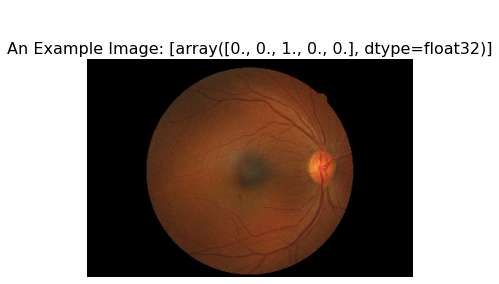

In [250]:
import random
rando = random.randint(0,len(valX)-1)
show(rando, 'An Example Image: {}'.format([valY[rando]]))

###Create the JSON object for a batch of three inference requests

In [251]:
import json
data = json.dumps({"signature_name": "serving_default", "instances": valX[0:3].tolist()})
print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))

Data: {"signature_name": "serving_default", "instances": ... 0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]]]}


### Make REST requests
Send a predict request as a POST to the server's REST endpoint and pass it three examples.

In [254]:
import requests

In [255]:
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8502/v1/models/fashion_model:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

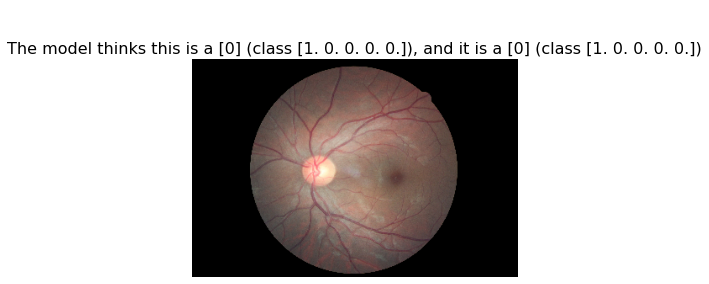

In [256]:
show(0, 'The model thinks this is a {} (class {}), and it is a {} (class {})'.format(
  [np.argmax(predictions[0])], valY[0], [np.argmax(predictions[0])], valY[0]))

### Specify a particular version of the servable 

In [258]:
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8502/v1/models/fashion_model/versions/1:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

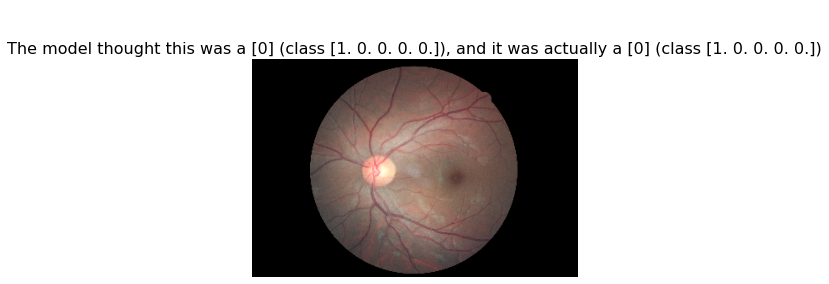

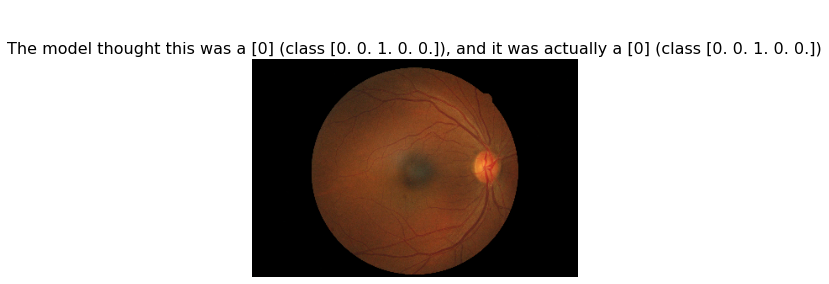

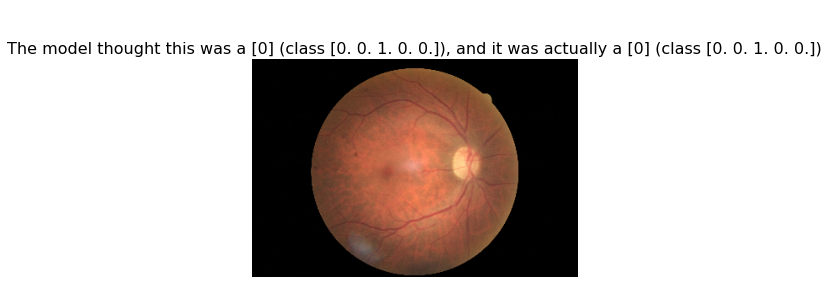

In [259]:
for i in range(0,3):
    show(i, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
    [np.argmax(predictions[i])], valY[i], [np.argmax(predictions[i])], valY[i]))